# NEVH - Numerical Evolution from the Hamiltonian (V2)

In [1]:
import sys
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#The following line makes modules in src/ accessible from the (current) test/ dir
sys.path.append("../src")
import nevh

## Simple Harmonic Motion

In [2]:
# Hamiltonian function
def H(t, s, k, m):
    x, p = s
    return 0.5*k*x**2 + 0.5*p**2/m

In [4]:
# Initial state: off equilibrium position, at rest
x0 = 1.0
p0 = 0.0
initial_state = [x0,p0]
# Integration steps parameters for partial derivatives dH/dq and dH/dp
ds = np.ones(2)*0.1
# Hamiltonian parameters. With k=4\pi^2, m=1, the period is 1
kc = 4 * np.pi**2
mc = 1
wc = (kc / mc)**0.5; Tc = 2 * np.pi / wc
tmin = 0; tmax = 2 * Tc # two full oscillation periods
G = nevh.Hgrad(H, ds, k=kc, m=mc)

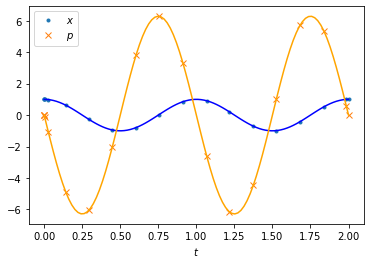

In [10]:
# Solve Hamilton's equations using simpy.solve_ivp
trj = solve_ivp(G, [tmin, tmax], initial_state)
# And that's it! Now plot the solution
t_nm = trj.t
x_nm, p_nm = trj.y
plt.plot(t_nm, x_nm, '.', label='$x$')
plt.plot(t_nm, p_nm, 'x', label="$p$")   # Plot of x and p
plt.legend()
# Compare with analytical solution
A = (x0**2 + (p0/(mc*wc))**2)**0.5
phi = np.arctan(-p0/(x0*mc*wc))
t_an = np.linspace(0,tmax,100)
x_an = A * np.cos(wc*t_an + phi)
p_an = -mc*wc*A * np.sin(wc*t_an + phi)
plt.plot(t_an,x_an,'b', t_an,p_an,'orange')
plt.xlabel('$t$')
plt.show();

## Two equal coupled oscilators

Two equal masses coupled to each other and to opposing walls of a box with equal springs.

In [ ]:
def H2(t, s, k, m, L):
    x1, x2, p1, p2 = s
    U = 0.5 * k * ( (x1 + L/6)**2 + (x2-x1 - L/3)**2 + (x2 - L/6)**2)
    T = 0.5 * (p1**2 + p2**2) / m
    return T + U

In [ ]:
s0 = np.array([0, 1./6, 0., 0.])   # Initial state
ds = np.ones(4) * 0.02             # Spatial discretization step 
kc = 1.0                           # Elastic constant
mc = 1.0                           # Mass
Lc = 1.0                           # Rest separation
tmin = 0.0; tmax = 20.0
F = nevh.Hgrad(H2, ds, k=kc, m=mc, L=Lc)
T = solve_ivp(F, [tmin, tmax], s0, max_step=0.1)
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.plot(T.t, T.y[0], label='$y_1$');
plt.plot(T.t, T.y[1], label='$y_2$');
plt.legend()
plt.show();

In [ ]:
plt.xlabel('$x_1$')
plt.ylabel('$p_1$')
plt.plot(T.y[0],T.y[1]); # Phase space trajectory of m1
plt.title("Phase space trajectory of $m_1$")
plt.show()

## Elastic pendulum

In [ ]:
from math import cos
def H3(t,s,m,g,l0,k):
    l, q, pl, pq = s
    T = (0.5 / m) * (pl**2 + (pq / l)**2)
    U = -m * g * l * cos(q) + 0.5 * k * (l - l0)**2
    return T + U

In [ ]:
s0 = np.array([1.0, 0.1, 0.0, 0.0])
ds = np.ones(4)*0.1
mc = 1.0; gc = 10.0; l0c = 1.0; kc = 1000.0
F3 = nevh.Hgrad(H3, ds, k=kc, m=mc, l0=l0c, g=gc)
tmin = 0.0; tmax = 10.0
T = solve_ivp(F3, [tmin, tmax], s0, max_step=0.05)
t = T.t
l, theta = T.y[:2]
plt.xlabel('$t$')
plt.plot(t, l, label="$l$")
plt.plot(t, theta, label=r"$\theta$");
plt.legend()
plt.show()


### Sun-Earth, CM frame, AU, SolarMass, year units

In [ ]:
def H5(t, s, G, M, mu):
    x, y, px, py = s
    V = -G * mu * M / (np.sqrt(x**2 + y**2))
    T = 1/(2 * mu) * (px**2 + py**2)
    return T + V

In [ ]:
grav_const = 39.4905
total_mass = 1.0
reduced_mass = 3.0034E-6
r0 = 1.0
p0 = reduced_mass * (grav_const * total_mass/r0)**0.5
s0 = np.array ([r0, 0, 0, p0])
ds = np.ones(4)*0.01
F5 = nevh.Hgrad(H5, ds, G=grav_const, M=total_mass, mu=reduced_mass)
tmin = 0.0; tmax = 20
T = solve_ivp(F5, [tmin, tmax], s0, max_step=0.02)
t = T.t
x,y = T.y[:2]
plt.axis('equal')
plt.plot(x,y);

### Sun-Earth-Moon, Sun fixed, AU, SolarMass, year units

In [ ]:
Ms = 1
def H6(t, s, G, m1, m2):
    x1, y1, x2, y2, px1, py1, px2, py2 = s
    V = -G * (Ms * m1 / np.sqrt(x1**2 + y1**2) + Ms * m2 / np.sqrt(x2**2 + y2**2) + 
              m1 * m2 / np.sqrt((x1-x2)**2 + (y1-y2)**2))
    T = 1/(2 * m1) * (px1**2 + py1**2) + 1/(2 * m2) * (px2**2 + py2**2)
    return T + V

In [ ]:
grav_const = 39.4905
me = 3.0034E-6
mm = 3.6923E-8
r0 = 1.0
r1 = 2.6E-3
p0 = me * (grav_const / r0)**0.5
p1 = 1*mm * (p0/me + (grav_const * me / r1)**0.5)
s0 = np.array ([r0, 0, r0+r1, 0, 0, p0, 0, p1])
ds = np.ones(8)*0.0001
F6 = nevh.Hgrad(H6, ds, G=grav_const, m1=me, m2=mm)
tmin = 0.0; tmax = 1
T = solve_ivp(F6, [tmin, tmax], s0, max_step=0.001)
t = T.t
x1,y1,x2,y2 = T.y[:4]
plt.axis('equal')
plt.plot(x1,y1,x2,y2);

In [ ]:
# Another Two Body System in a central field
grav_const = 39.4905
me = 3.0034E-1
mm = 3.6923E-7
r0 = 1.0
r1 = 1.2
p0 = me * (grav_const / r0)**0.5
p1 = 0.2*mm * (p0/me + (grav_const * me / r1)**0.5)
s0 = np.array ([r0, 0, r1, 0, 0, p0, 0, p1])
ds = np.ones(8)*0.00001
F6b = nevh.Hgrad(H6, ds, G=grav_const, m1=me, m2=mm)
tmin = 0.0; tmax = 1.
T = solve_ivp(F6b, [tmin, tmax], s0, max_step=0.0005)
t = T.t
x1,y1,x2,y2 = T.y[:4]
plt.axis('equal')
plt.plot(x1,y1,x2,y2);


### Double Pendulum

$$
H(\theta_1, \theta_2, \dot\theta_1, \dot\theta_2)=\frac{1}{2}(m_1+m_2)l_1^2\dot\theta_1^2
+\frac{1}{2}m_2l_2^2\dot\theta_2^2
+m_2l_1l_2\dot\theta_1\dot\theta_2\cos(\theta_2-\theta_1)+
(m_1+m_2)gl_1\cos\theta_1-m_2gl_2\cos\theta_2
$$

In [ ]:
from math import cos, sin
def H7(t, s, m1, m2, l1, l2, g):
    q1, q2, p1, p2 = s
    T1 = m2 * l2**2 * p1**2
    T2 = (m1 + m2) * l1**2 * p2**2
    T3 = -2 * m2* l1 * l2 * p1 * p2 * cos(q1-q2)
    Td = 2 * m2 * l1**2 * l2**2 * (m1 + m2 * (sin(q1 - q2))**2)
    T = (T1 + T2 + T3) / Td
    U1 = -(m1 + m2) * g * l1 * cos(q1)
    U2 = -m2 * g * l2 * cos(q2)
    U = U1 + U2
    return T + U

In [ ]:
m1n = 1.0
m2n = 0.01
l1n = 1.0
l2n = 1.0
gn = 10.0
q2 = 0.0
q1 = np.pi / 36
p1 = 0.0
p2 = 0.0
s0 = np.array([q1, q2, p1, p2])
ds = np.ones(4)*0.0001
F7 = nevh.Hgrad(H7, ds, m1=m1n, m2=m2n, l1=l1n, l2=l2n, g=gn)
tmin = 0.0; tmax = 50
T = solve_ivp(F7, [tmin, tmax], s0, max_step=0.001)
t = T.t
q1,q2,p1,p2 = T.y[:4]
plt.plot(t,q1, t,q2);

### Lotka-Volterra